## Аналитика в интернет-магазине

Наши задачи - 1) проанализировать список гипотез для увеличения выручки и определить их приоритет, 2) проанализировать результаты А/B теста.

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

### Шаг 0. Чтение данных и их предобработка.

In [2]:
hypo = pd.read_csv('datasets/hypothesis.csv') # прочитаем данные для первого блока задач
hypo.columns = hypo.columns.str.lower() # переведем все показатели в нижний регистр для удобства работы
pd.set_option('display.max_colwidth', -1) # разрешим выводить все содержимое ячейки

In [3]:
orders = pd.read_csv('datasets/orders.csv') # прочитаем данные для второго блока задач
visitors = pd.read_csv('datasets/visitors.csv')

In [4]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) # приведем данные по датам к нужному формату
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Шаг 1. Приоритизация гипотез.

In [5]:
hypo['ICE'] = (hypo['impact'] * hypo['confidence']) / hypo['efforts'] # применим фреймворк ICE
hypo.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


In [6]:
hypo['RICE'] = (hypo['reach'] * hypo['impact'] * hypo['confidence']) / hypo['efforts'] # применим фреймворк RICE
hypo.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


#### Выводы: 

учёт параметра Reach ощутимо изменил приоритет гипотез: так, предложение о скидке в день рожденья опустилось с 1го места на 5ое, так как оно достигнет лишь 1/365 часть пользователей; в то же время поднялись гипотезы с хорошим охватом - гипотеза о форме подписки (возможность собрать базу email'ов обусловила подъем с 3го места на 1ое) и гипотеза о блоках рекомендаций (предполагается, что рекомендациями воспользуется много пользователей (подъем с 5го места на 2ое)).

### Шаг 2. Анализ A/B-теста

Наша гипотеза: внедрение некоего изменения повысила конверсию и средний чек. Проверим это на основании данных A/B теста.

#### Шаг 2.1. Изучение кумулятивной выручки по группам.

In [7]:
# подсчитаем количество заказов и выручку по дням
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [8]:
# подсчитаем кумулятивные количество заказов и выручку
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg({
                'date' : 'max', 'ordersPerDateA' : 'sum', 'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg({
                'date' : 'max', 'ordersPerDateB' : 'sum', 'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [9]:
# объединим полученные таблицы
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')

In [10]:
# создадим функцию для отрисовки графиков кумулятивных показателей
def two_groups_plot(first_data, second_data, target_index):
    plt.plot(data['date'], first_data, label='A')
    plt.plot(data['date'], second_data, label='B')
    plt.legend()
    plt.xlabel('Дата')
    plt.ylabel(target_index)
    plt.title(target_index+' по группам')
    plt.xticks(rotation='vertical')

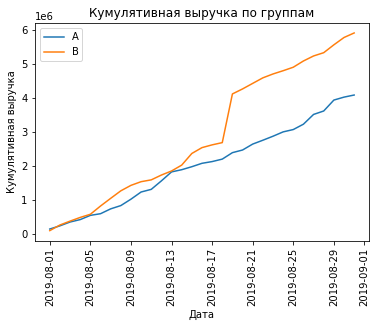

In [11]:
# построим график кумулятивной выручки по группам
two_groups_plot(data['revenueCummulativeA'], data['revenueCummulativeB'], 'Кумулятивная выручка')

#### Вывод: 
в третьей декаде месяца кумулятивная выручка группы B стала резко превосходить кумулятивную выручку группы B. Характер роста заставляет предположить влияние одного (или нескольких) крупных заказов в группе B, исказивших картину.

#### Шаг 2.2. Изучение среднего чека по группам.

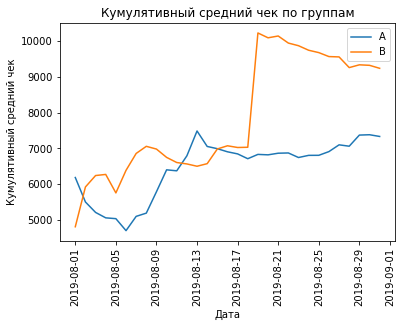

In [12]:
# построим график кумулятивного среднего чека по группам

two_groups_plot(data['revenueCummulativeA']/data['ordersCummulativeA'], data['revenueCummulativeB']/data['ordersCummulativeB'], 'Кумулятивный средний чек')

#### Вывод: 
Анализ среднего чека подтверждает нашу догадку: в результате крупного заказа средний чек группы B резко вырос, а затем стал закономерно снижаться к нормальному значению.

In [13]:
# создадим функцию для отрисовки графиков отношений показателей групп
def ratio_plot(first_data, second_data, target_index):
    plt.plot(data['date'], (second_data/first_data)-1)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Дата')
    plt.ylabel('Отношение')
    plt.title('Отношение показателя "'+target_index+'" группы B \n к тому же показателю группы A')
    plt.xticks(rotation='vertical')

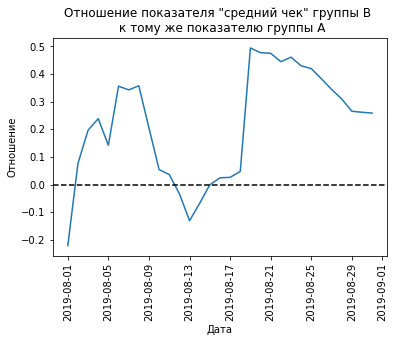

In [14]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A
ratio_plot(data['revenueCummulativeA']/data['ordersCummulativeA'], data['revenueCummulativeB']/data['ordersCummulativeB'], 'средний чек')

#### Вывод: 
В начале месяца кумулятивный средний чек группы B превосходил группу A (разница достигала 30%), к середине месяца снизился до уровня группы A, однако в результате крупного заказа в конце второй декады вновь стал превосходить группу A.

#### Шаг 2.3. Изучение конверсии по группам.

In [15]:
# подсчитаем кумулятивное количество посетителей по группам
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [16]:
# объединим полученные таблицы
data = data.merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [17]:
# подсчитаемм кумулятивную конверсию по группам
data['conversionA'] = data['ordersCummulativeA']/data['visitorsCummulativeA']
data['conversionB'] = data['ordersCummulativeB']/data['visitorsCummulativeB']

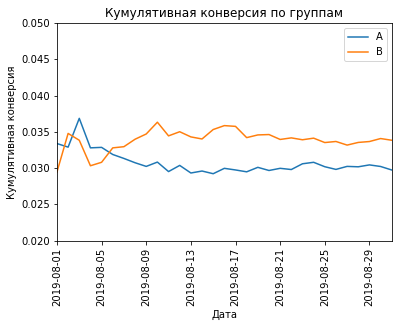

In [18]:
two_groups_plot(data['conversionA'], data['conversionB'], 'Кумулятивная конверсия')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.02, 0.05])
plt.show()

##### Вывод: 
начиная с 6 августа конверсия группы B устойчиво превосходит конверсию группы A.

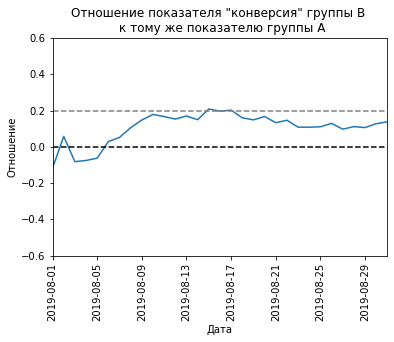

In [19]:
plt.figure(figsize=(6, 4))
ratio_plot(data['conversionA'], data['conversionB'], 'конверсия')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.6, 0.6])
plt.show()

#### Вывод: 
преимущество конверсии группы B над группой A составляет около 10-20%. Выясним, является ли разница в конверсиях статистически значимой, в шаге 2.5.

#### Шаг 2.4. Изучаем границы нормального поведения пользователей (по количеству заказов и их стоимости).

In [20]:
# подсчитаем количество заказов у каждого пользователя
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['userId','orders']

Text(0.5, 0, 'Количество заказов')

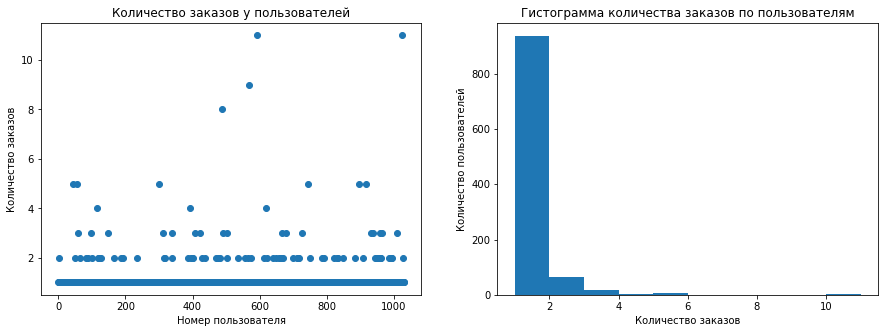

In [21]:
#  построим график с распределением количества заказов по пользователям

x_values = pd.Series(range(0,len(ordersByUsers)))

fig = plt.figure(figsize=(15, 5))
area = fig.add_subplot(1, 2, 1)
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов')
plt.title('Количество заказов у пользователей')

area = fig.add_subplot(1, 2, 2)
plt.hist(ordersByUsers['orders'])
plt.title('Гистограмма количества заказов по пользователям')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество заказов')


In [22]:
# подсчитаем 95-й и 99-й перцентили количества заказов на пользователя

np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

#### Вывод: 
большинство покупателей делает только 1 заказ, еще часть 2, и только менее 5 % делают 3 и более заказов. Границей определения аномальности выберем 2 заказа.

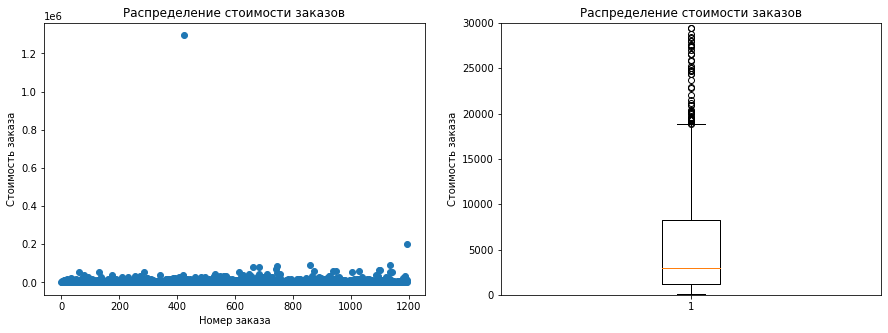

In [23]:
# построим график с распределением стоимости заказов
x_values = pd.Series(range(0, len(orders['revenue'])))

fig = plt.figure(figsize=(15, 5))
area = fig.add_subplot(1, 2, 1)
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Номер заказа')
plt.ylabel('Стоимость заказа')
plt.title('Распределение стоимости заказов')

area = fig.add_subplot(1, 2, 2)
plt.boxplot(orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylim(0, 30000)
plt.ylabel('Стоимость заказа')
plt.show()

In [24]:
# подсчитаем 95-й и 99-й перцентили стоимости заказов

np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

#### Вывод:
95 % заказов сделано на сумму до 28 000 р. (а медиана и вовсе расположена в районе 2-3 тысяч). Выберем 28 000 р. границей аномальности (кстати, видим аномально дорогой выброс на сумму более 1,2 млн. р., который мы предполагали ранее).

#### Шаг 2.5. Проверка статистической значимости различий между группами.

In [25]:
# создадим коротую функцию для проверки гипотез

def hypo_check(first_data, second_data, target_index):
    print("p-значение составило: {0:.3f}".format(stats.mannwhitneyu(first_data, second_data)[1]))
    print(target_index,"группы B /", target_index, "группы A - 1 = {0:.3f}".format(second_data.mean()/first_data.mean()-1))

In [26]:
# подсчитаем статистическую значимость различий в конверсии между группами по «сырым» данным
# наша нулевая гипотеза - количество заказов на посетителя в группе A равно количеству заказов на посетителя в группе B
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

hypo_check(sampleA, sampleB, 'конверсия')

p-значение составило: 0.008
конверсия группы B / конверсия группы A - 1 = 0.138


#### Вывод:
наше p-значение составило лишь 0.008, значит, мы должны отбросить нашу нулевую гипотезу о равенстве конверсий. Разница в конверсии между группами статистически значима (на сырых данных), и, как мы видели на графике, конверсия группы B выше конверсии группы A. Разница средних значений составила 13,8 %.

In [27]:
# подсчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
# наша нулевая гипотеза - средний чек в группе A равен среднему чеку в группе B
hypo_check(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], 'средний чек')

p-значение составило: 0.365
средний чек группы B / средний чек группы A - 1 = 0.259


#### Вывод: 
наше p-значение составило 0.365, значит, мы не можем отбросить нашу нулевую гипотезу о равенстве средних чеков (на сырых данных). Cредний чек группы B на 25.9 % превышает средний чек группы A, однако эти различия статистически не значимы.

In [28]:
# найдем пользователей со слишком большим количеством заказов или слишком дорогими заказами

usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [29]:
# очистим наши данные от этих пользователей

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [30]:
# подсчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным
# наша нулевая гипотеза - конверсия в группе A (на очищенных данных) равна конверсии в группе B (на очищенных данных)
hypo_check(sampleAFiltered, sampleBFiltered, 'конверсия')

p-значение составило: 0.007
конверсия группы B / конверсия группы A - 1 = 0.173


#### Вывод:
Результаты анализа конверсии на очищенных данных подтвердили наши предварительные выводы по сырым данным: p-значение стало еще меньше, значит, гипотезу об отсутствии значимых различий снова нужно отбросить; разница в конверсии между группами вновь статистически значима (на очищенных данных разница составила 17 % в пользу группы B).

In [31]:
# подсчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
# наша нулевая гипотеза - средний чек в группе A (на очищенных данных) равен среднему чеку в группе B (на очищенных данных)

clear_A = orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
clear_B = orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

hypo_check(clear_A, clear_B, 'средний чек')

p-значение составило: 0.369
средний чек группы B / средний чек группы A - 1 = -0.020


#### Вывод:
Результаты анализа средних чеков на очищенных данных подтвердили наши предварительные выводы: p-значение осталось высоким, значит, мы по-прежнему не можем отбросить нашу нулевую гипотезу о равенстве средних чеков. Вместе с тем выяснилось, что  средний чек на очищенных данных примерно одинаков у обеих групп.

### Итоги по шагу 2:

В ходе нашего исследования мы:

1. Проанализировали графики изменения кумулятивного среднего чека и конверсии и отношение этих показателей между группами.
2. Построили распределение количества заказов у одного пользователя и их стоимость, в результате чего очистили наши данные от покупателей с аномальным поведением.
3. Выяснили, насколько статистически значимо отличаются показатели среднего чека и конверсии между группами на сырых и на очищенных данных.

В результате мы можем сказать следующее:

1. Различия в конверсии групп статистически значима. Разница составляет в среднем 13,8 % на сырых данных и 17.3 % на очищенных данных в пользу группы B. Разница конверсий стабильна и отмечается на протяжении всего эксперимента, начиная с 6 августа.

2. Cредний чек группы B превосходит аналогичный показатель группы A, однако это было достигнуто в связи с малым количеством аномально дорогих заказов. Применение критерия Манна-Уитни показывает, что статистически значимой разницы в среднем чеке нет ни на сырых, ни на очищенных данных. 

3. По итогам A/B теста группу B можно признать победителем по показателю "конверсия" (он устойчиво выше конверсии группы А). Показатель отношения средних чеков ведёт себя нестабильно в связи с наличием выбросов в виде дорогих заказов, однако исходя из анализа графика на последнем этапе и исследования статистической значимости различий мы можем предположить, что средние чеки групп будут стремиться к равенству. В связи с этим тест можно останавливать.

#### Рекомендации для маркетологов:

Внедрение нашего изменения оказалось удачным, оно увеличило конверсию на 17 %, хоть и не привело к статистически значимому увеличению среднего чека. Стоит закрепить эту практику.

В настоящий момент стоит провести тестирование остальных гипотез, обладающих высоким приоритетом согласно RICE-фреймворку: 

    1) добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    2) добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
    3) добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Кроме того, следует провести интервью с пользователями, сделавшими аномально дорогие заказы, чтобы выяснить, что их привлекло. Возможно, это даст нам идеи для новых гипотез о методах увеличения среднего чека.